In [44]:
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import seaborn as sb
import aplpy
import healpy as hp
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from drizzlib.healpix2wcs import healpix2wcs
from   pylab import arange, show, cm
import matplotlib.gridspec as gridspec    
from matplotlib.colors import SymLogNorm
import astropy.io.fits as fits
cmap = cm.rainbow
cmap.set_under('w')
### For eading .h5 files such as those provided by Fred
import h5py as H5

plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

#### Note from Fred on how to read-in the .h5 file with MCMC results for Lambda Orionis

To read this file in Python, you just need to do:  
```
    import h5py as H5
    f = H5.File("lorionis_res.h5","r")
    param = f["Parameter name"].value
```
    
where "Parameter name" can be:  
    **Mask**: the 2D mask where the model has been computed;  
    **I_ame**: the intensity of the AME;  
    **lnUav**: the natural logarithm of the average ISRF intensity;  
    **lnMd**: the natural logarithm of the dust mass;  
    **q_PAH**: the PAH mass fraction (M_PAH/M);  
    **f_ion**: the fraction of charged PAHs (MPAH+/M_PAH).  
    
Each of these parameters are arrays of size **[Nx,Ny,Nmcmc]** (except the mask). To interpret these results, for each step in the MCMC, you build the quantities you want to study (combination of any of these parameters, e.g. the correlation coefficient of **I_ame/Uav** with **lnMd** in a given **[x,y]** region of the map). You will end up with **Nmcmc** values for this quantity. These values give you the PDF of your quantity.

    Fred

In [2]:
lorionis_res_path = "../../CosmicDust_BFS/Data/parfits/MCMC/lorionis_res.h5"
par_names = ["Mask","I_ame", "lnUav", "lnMd", "q_PAH","f_ion"]



In [3]:
f = H5.File(lorionis_res_path,"r")

In [4]:
f.items()

[(u'I_ame', <HDF5 dataset "I_ame": shape (40001, 50, 50), type "<f8">),
 (u'Mask', <HDF5 dataset "Mask": shape (50, 50), type "|u1">),
 (u'f_ion', <HDF5 dataset "f_ion": shape (40001, 50, 50), type "<f8">),
 (u'lnM', <HDF5 dataset "lnM": shape (40001, 50, 50), type "<f8">),
 (u'lnUav', <HDF5 dataset "lnUav": shape (40001, 50, 50), type "<f8">),
 (u'q_PAH', <HDF5 dataset "q_PAH": shape (40001, 50, 50), type "<f8">)]

In [13]:
Mask  = f["Mask"].value
Iame  = f["I_ame"].value
lnUav = f["lnUav"].value
lnMd  = f["lnM"].value
qPAH  = f["q_PAH"].value
fion  = f["f_ion"].value

#### Confirm that Mask value of 1 correspondes to data value of 0

In [14]:
Iame[:,Mask==1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
Iame[1,20,9]

6.0694744331339709

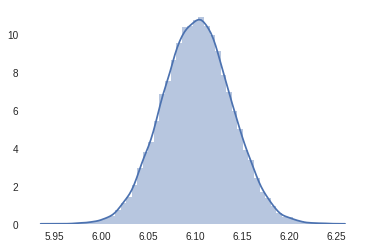

In [45]:
sb.distplot(Iame[:,20,9])

In [17]:
#%%timeit
def getCorrScore(x,y,mask_array, mask_value,how):
    if how == 'pearson':
        result = scipy.stats.pearsonr(x[mask_array==mask_value], y[mask_array==mask_value])
    elif how == 'spearman':
        result = scipy.stats.spearmanr(x[mask_array==mask_value], y[mask_array==mask_value])
    
    return result[0]


def getCorrScoreForMCMCSlice(x,y,slice, mask_array, mask_value, how):
    return getCorrScore(x[slice,],y[slice,], mask_array, mask_value, how)


def getCorrScorePDF(Nmcmc, x, y, mask_array, mask_value, how='spearman'):
    Corr_PDF = np.ones(Nmcmc)
    for i in range(0, Nmcmc):
        Corr_PDF[i] = getCorrScoreForMCMCSlice(x, y, i, mask_array, mask_value, how)
    
    return Corr_PDF


In [18]:
Iame_vs_qPAH_CorrPDF_spearman = getCorrScorePDF(40001, Iame, qPAH, mask_array=Mask, mask_value=0, how='spearman')
Iame_vs_qPAH_CorrPDF_pearson = getCorrScorePDF(40001, Iame, qPAH, mask_array=Mask, mask_value=0, how='pearson')

Ok, so we found that we can get a correlation score by acessing the unmasked values this way.
Now we just loop over the MCMC values, where we now have just a "1". We could also try to do it in a vectorized way.

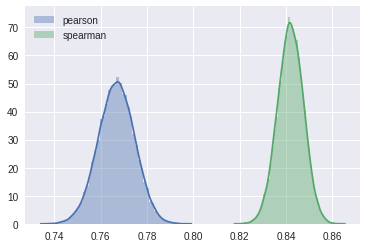

In [19]:
sb.distplot(Iame_vs_qPAH_CorrPDF_pearson, label="pearson")
sb.distplot(Iame_vs_qPAH_CorrPDF_spearman, label="spearman")
plt.legend()

Ok, so it looks like we're getting a nice PDF out of all that. What I'd like to do now is look at the parameters which we examined in my thesis.
This is fairly trivial. We just get M_PAH from q_PAH*Md.
We already have Md in our parameters, just that its in log from. So lets exponentiate and multiply by q_PAH.
In the thesis we looked at I_ame / U, so we'll exponetiate lnUav as well.

In [21]:
Mpah      = np.exp(lnMd.copy())*qPAH.copy()
Mpahion   = np.exp(lnMd.copy())*qPAH.copy()*fion.copy()
Uav       = np.exp(lnUav.copy())
Md        = np.exp(lnMd.copy())

lnMpah    = np.log(Mpah.copy())
lnMpahion = np.log(Mpahion.copy())

Mame = Iame.copy()/Uav.copy()

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


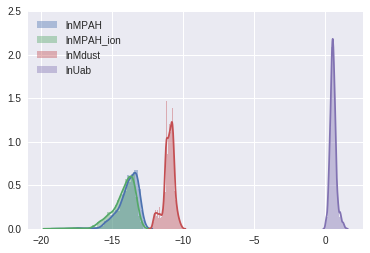

In [43]:
sb.distplot(lnMpah[1000,Mask==0], label="lnMPAH")
sb.distplot(lnMpahion[1000,Mask==0], label="lnMPAH_ion")
sb.distplot(lnMd[1000,Mask==0],label="lnMdust")
sb.distplot(lnUav[1000,Mask==0],label="lnUab")
plt.legend()

In [36]:
PDF_Md_Iame      = getCorrScorePDF(40001, Iame, lnMd,      mask_array=Mask, mask_value=0)
PDF_Mpah_Iame    = getCorrScorePDF(40001, Iame, lnMpah,    mask_array=Mask, mask_value=0)
PDF_Mpahion_Iame = getCorrScorePDF(40001, Iame, lnMpahion, mask_array=Mask, mask_value=0)

In [37]:
PDF_Md_Mame      = getCorrScorePDF(40001, Mame, lnMd,      mask_array=Mask, mask_value=0)
PDF_Mpah_Mame    = getCorrScorePDF(40001, Mame, lnMpah, mask_array=Mask, mask_value=0)
PDF_Mpahion_Mame = getCorrScorePDF(40001, Mame, lnMpahion, mask_array=Mask, mask_value=0)

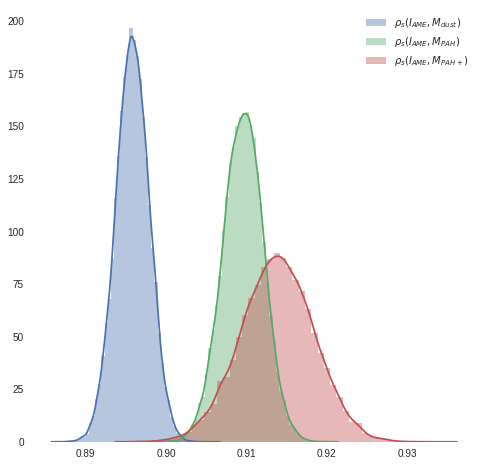

In [57]:
plt.figure(figsize=(8,8))
sb.distplot(PDF_Md_Iame, label="$\\rho_{s}(I_{AME},M_{dust})$", norm_hist=True)
sb.distplot(PDF_Mpah_Iame, label="$\\rho_{s}(I_{AME},M_{PAH})$", norm_hist=True)
sb.distplot(PDF_Mpahion_Iame, label="$\\rho_{s}(I_{AME},M_{PAH+})$", norm_hist=True)
#plt.xlim(0.5,1.0)
plt.legend()
plt.savefig('../Plots/ch_lori/PDFs_Iame.pdf')

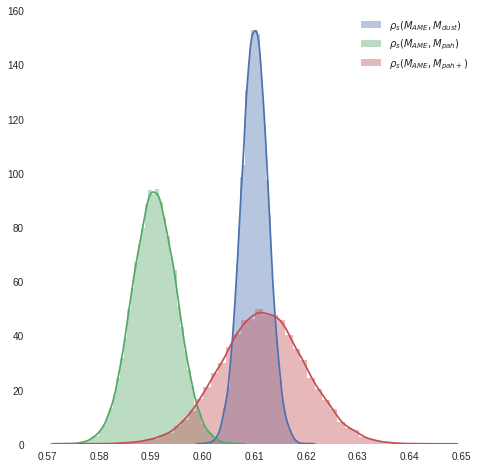

In [55]:
plt.figure(figsize=(8,8))
sb.distplot(PDF_Md_Mame, label="$\\rho_{s}(M_{AME},M_{dust})$", norm_hist=True)
sb.distplot(PDF_Mpah_Mame, label="$\\rho_{s}(M_{AME},M_{pah})$", norm_hist=True)
sb.distplot(PDF_Mpahion_Mame, label="$\\rho_{s}(M_{AME},M_{pah+})$", norm_hist=True)
#plt.xlim(0.5,1.0)
plt.legend()
plt.savefig('../Plots/ch_lori/PDFs_Iame_Uav.pdf')

#### Trying another way to open the .h5 directly with Pandas:
https://pandas.pydata.org/pandas-docs/stable/io.html#io-hdf5

In [ ]:
parms = pd.read_hdf(lorionis_res_path)

#### Now let's define a new mask, that excludes the central region of $\lambda$ Orionis

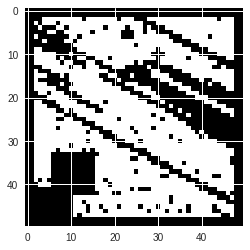

In [29]:
plt.imshow(Mask)

### But what if we want a circular mask?
based on https://stackoverflow.com/questions/44865023/circular-masking-an-image-in-python-using-numpy-arrays

In [63]:
def circMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

mask_circle_r5 = circMask(50,50, radius=10)

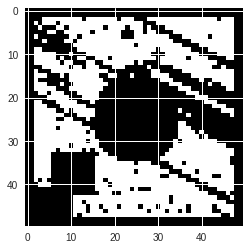

In [64]:
Mask_center = Mask.copy()
Mask_center[mask_circle_r5]  = 1
plt.imshow(Mask_center)

In [65]:
PDF_Id_Iame_Mask_center      = getCorrScorePDF(40001, Iame, lnMd, mask_array=Mask_center, mask_value=0)
PDF_Ipah_Iame_Mask_center    = getCorrScorePDF(40001, Iame, lnMpah, mask_array=Mask_center, mask_value=0)
PDF_Ipahion_Iame_Mask_center = getCorrScorePDF(40001, Iame, lnMpahion, mask_array=Mask_center, mask_value=0)

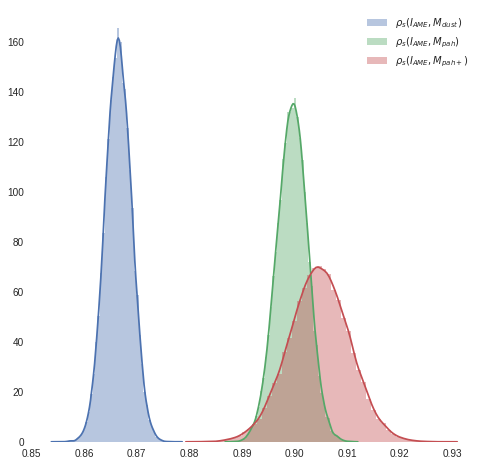

In [66]:
plt.figure(figsize=(8,8))
sb.distplot(PDF_Id_Iame_Mask_center, label="$\\rho_{s}(I_{AME},M_{dust})$", norm_hist=True)
sb.distplot(PDF_Ipah_Iame_Mask_center, label="$\\rho_{s}(I_{AME},M_{pah})$", norm_hist=True)
sb.distplot(PDF_Ipahion_Iame_Mask_center, label="$\\rho_{s}(I_{AME},M_{pah+})$", norm_hist=True)
#plt.xlim(0.5,1.0)
plt.legend()
plt.savefig('../Plots/ch_lori/PDFs_center_masked_Iame.pdf')